In [1]:
import numpy as np
from RNN_model import *
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx
import random

In [2]:
import math

# Start and end are lists defining start and end points
# Edge x and y are lists used to construct the graph
# arrowAngle and arrowLength define properties of the arrowhead
# arrowPos is None, 'middle' or 'end' based on where on the edge you want the arrow to appear
# arrowLength is the length of the arrowhead
# arrowAngle is the angle in degrees that the arrowhead makes with the edge
# dotSize is the plotly scatter dot size you are using (used to even out line spacing when you have a mix of edge lengths)
def addEdge(start, end, edge_x, edge_y, lengthFrac=1, arrowPos = None, arrowLength=0.025, arrowAngle = 30, dotSize=20):
    
    # Get start and end cartesian coordinates
    x0, y0 = start
    x1, y1 = end
    
    # Incorporate the fraction of this segment covered by a dot into total reduction
    length = math.sqrt( (x1-x0)**2 + (y1-y0)**2 )
    dotSizeConversion = .0565/20 # length units per dot size
    convertedDotDiameter = dotSize * dotSizeConversion
    lengthFracReduction = convertedDotDiameter / length
    lengthFrac = lengthFrac - lengthFracReduction
    
    # If the line segment should not cover the entire distance, get actual start and end coords
    skipX = (x1-x0)*(1-lengthFrac)
    skipY = (y1-y0)*(1-lengthFrac)
    x0 = x0 + skipX/2
    x1 = x1 - skipX/2
    y0 = y0 + skipY/2
    y1 = y1 - skipY/2
    
    # Append line corresponding to the edge
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None) # Prevents a line being drawn from end of this edge to start of next edge
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    
    # Draw arrow
    if not arrowPos == None:
        
        # Find the point of the arrow; assume is at end unless told middle
        pointx = x1
        pointy = y1
        eta = math.degrees(math.atan((x1-x0)/(y1-y0)))
        
        if arrowPos == 'middle' or arrowPos == 'mid':
            pointx = x0 + (x1-x0)/2
            pointy = y0 + (y1-y0)/2
            
        # Find the directions the arrows are pointing
        signx = (x1-x0)/abs(x1-x0)
        signy = (y1-y0)/abs(y1-y0)
        
        # Append first arrowhead
        dx = arrowLength * math.sin(math.radians(eta + arrowAngle))
        dy = arrowLength * math.cos(math.radians(eta + arrowAngle))    
        edge_x.append(pointx)
        edge_x.append(pointx - signx**2 * signy * dx)
        edge_x.append(None)
        edge_y.append(pointy)
        edge_y.append(pointy - signx**2 * signy * dy)
        edge_y.append(None)
        
        # And second arrowhead
        dx = arrowLength * math.sin(math.radians(eta - arrowAngle))
        dy = arrowLength * math.cos(math.radians(eta - arrowAngle))    
        edge_x.append(pointx)
        edge_x.append(pointx - signx**2 * signy * dx)
        edge_x.append(None)
        edge_y.append(pointy)
        edge_y.append(pointy - signx**2 * signy * dy)
        edge_y.append(None)
    
    
    return edge_x, edge_y

In [166]:
num_nodes = 250
G = nx.random_geometric_graph(num_nodes, 0.15)

edge_x = []
edge_y = []
list_of_all_arrows = []
edges = []
for edge in G.edges():
    edge = np.array(edge)
    if np.random.uniform(-1, 1) > 0:
        edge[0], edge[1] = edge[1], edge[0]
    edges.append(edge)
    x0, y0 = G.nodes[edge[0]]['pos']
    
    x1, y1 = G.nodes[edge[1]]['pos']
    
    addEdge((x0, y0), (x1, y1), edge_x, edge_y, arrowPos = 'middle', arrowLength = 0.01, dotSize = 0)
edges = np.array(edges)
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
colors=[]
widths = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)
    if node == 0:
        colors.append('black')
        widths.append(10)
    else:
        colors.append('black')
        widths.append(3)
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        #showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        #colorscale='YlGnBu',
        #reversescale=True,
        color=[],
        size=20,
        line=dict(width=widths, color = colors)
    ))
node_nums= []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_nums.append(node)
    node_text.append('Node #: '+str(node))

#node_trace.marker.color = node_adjacencies
node_trace.text = node_text

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()

In [329]:

print(edges.shape)
a = RNN(num_nodes, edges, inputs = [], feedback = False, recurrent_weight = np.random.normal(1, .1, num_nodes), num_outputs = 1, activation_type = "tanh", init_weights = ["randomUniform", [-.2, .2]], init_activations = ["randomUniform", [-1, 1]])

(1949, 2)


In [330]:
a.simulate(1000)

In [331]:
a.edges.shape

(2449, 2)

In [332]:
#inputs = a.get_input_signals()

#plt.plot(range(101), inputs[1])

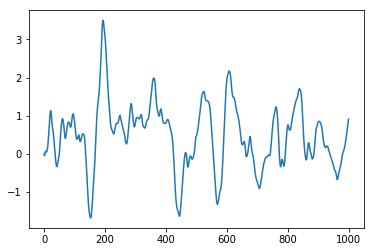

In [333]:
outputs = a.get_output_activations()
for i in range(1):
    fig, ax = plt.subplots()
    plt.plot(range(1001), outputs[i])
    plt.show()

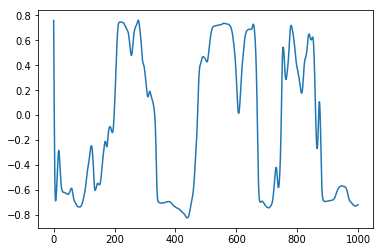

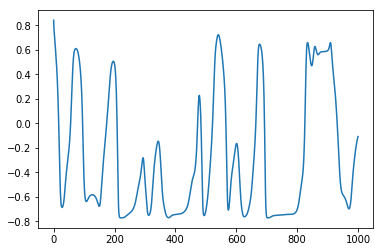

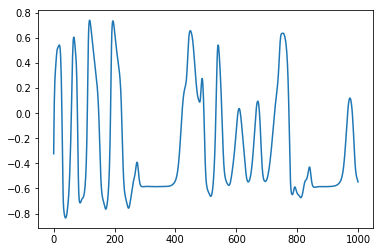

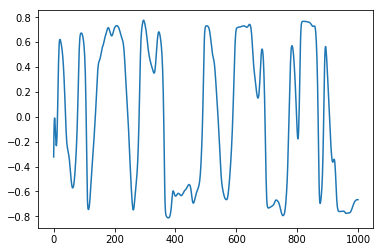

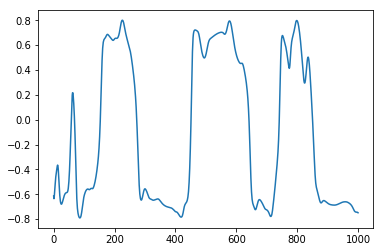

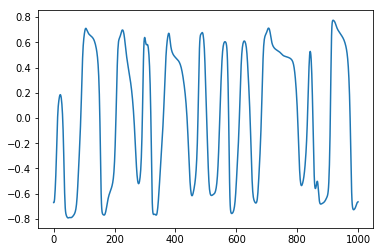

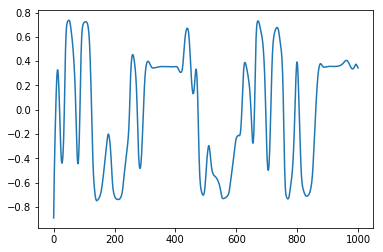

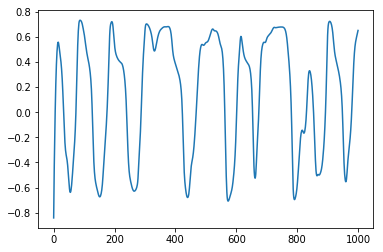

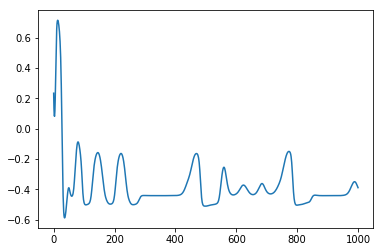

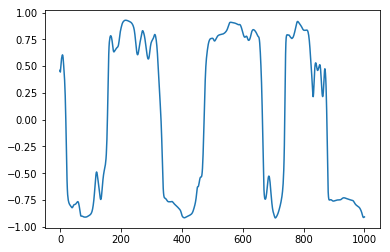

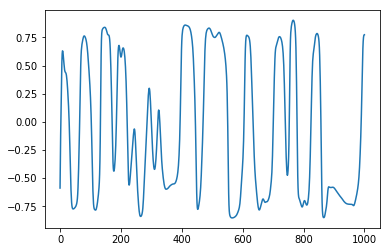

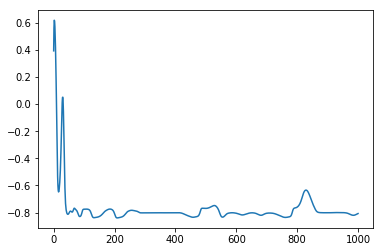

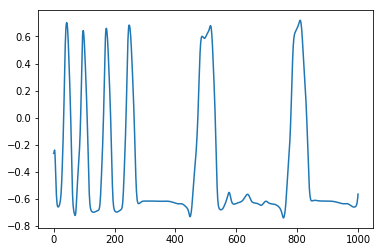

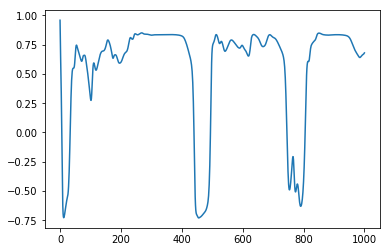

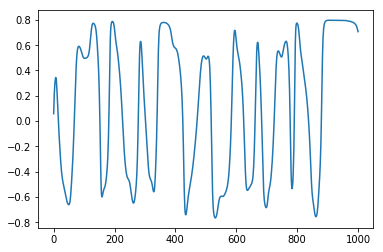

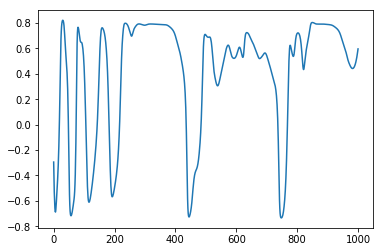

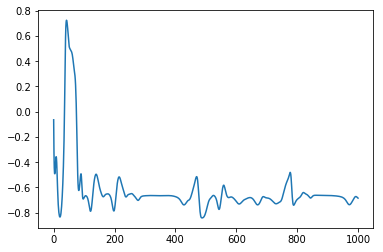

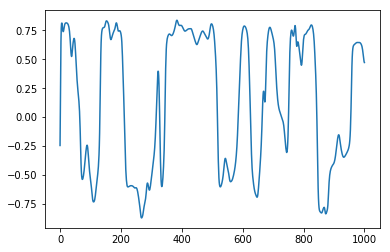

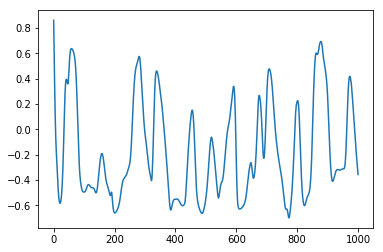

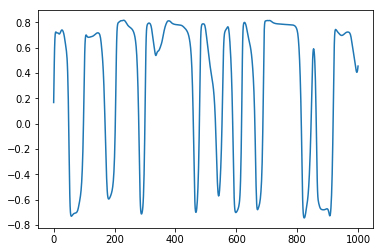

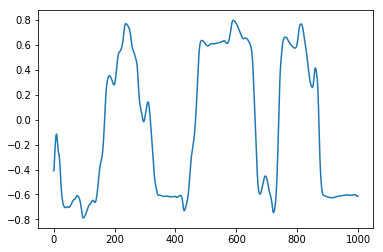

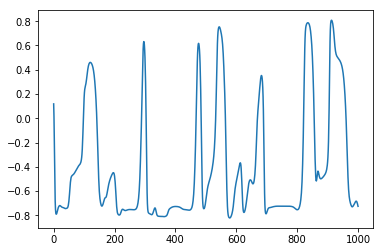

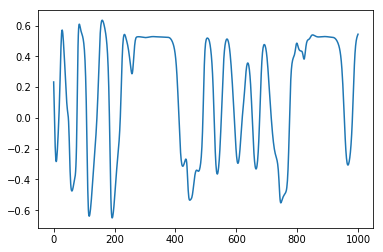

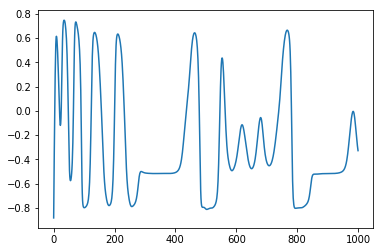

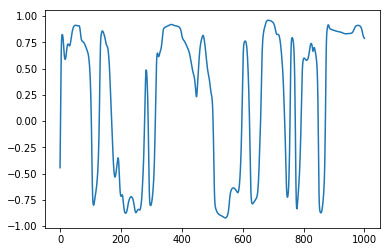

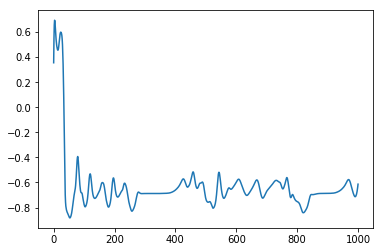

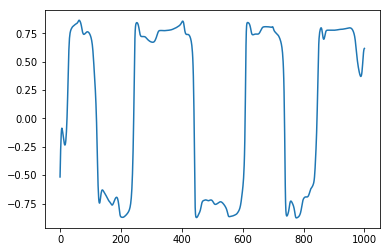

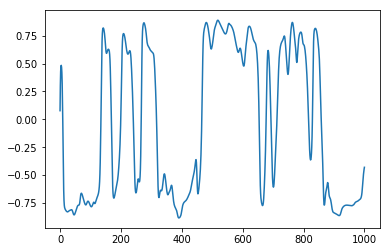

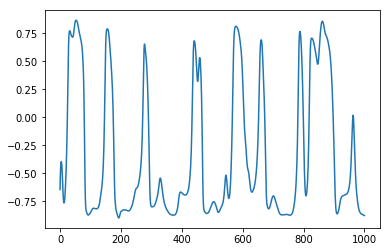

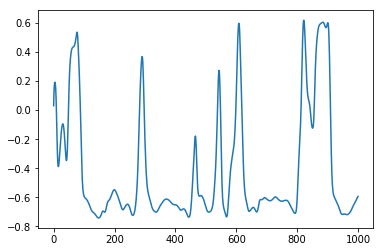

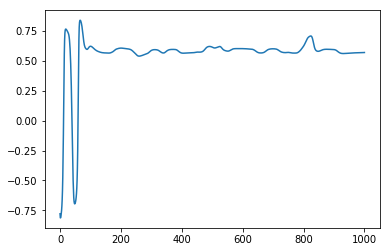

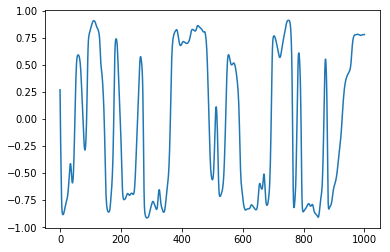

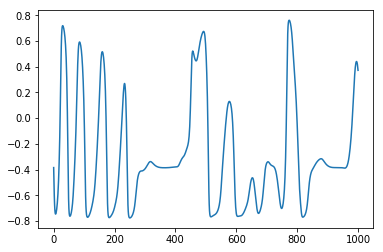

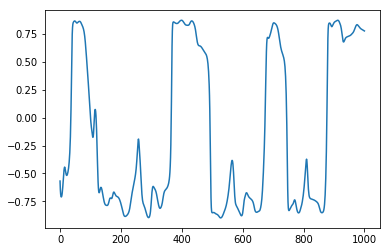

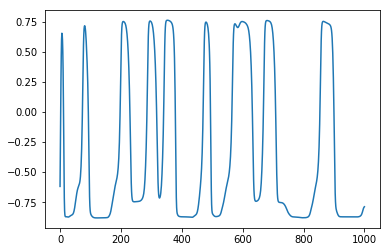

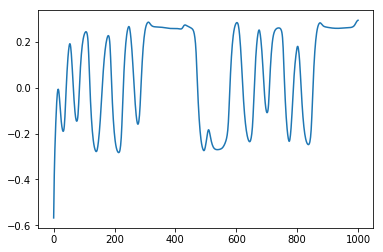

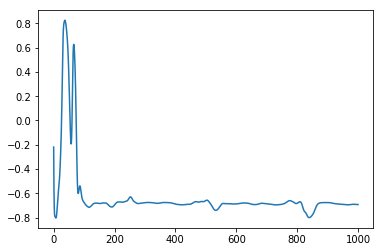

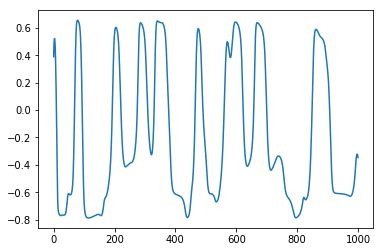

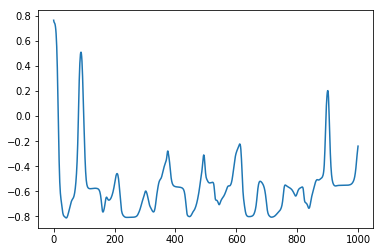

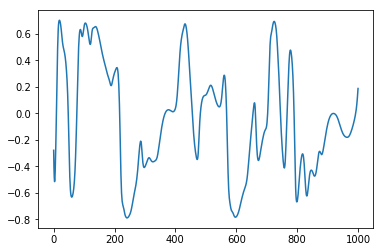

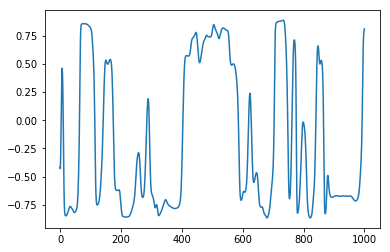

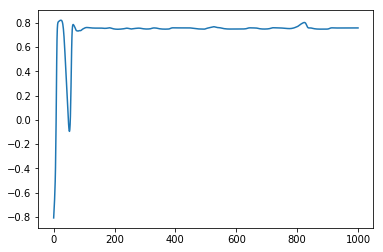

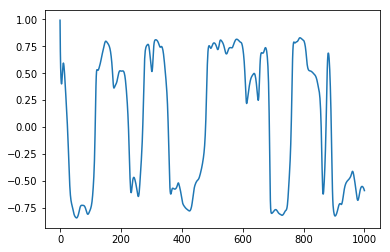

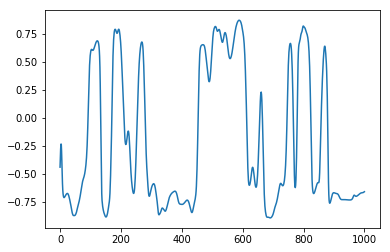

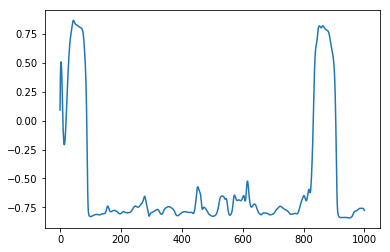

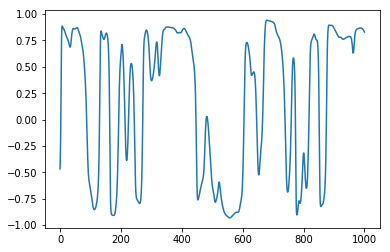

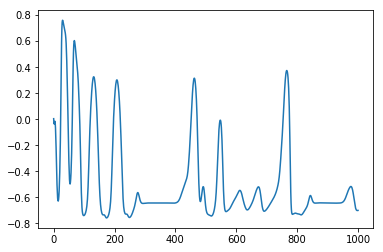

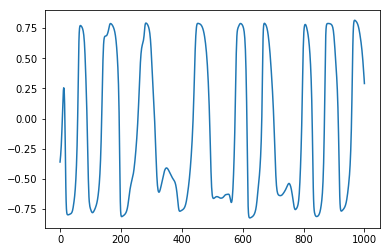

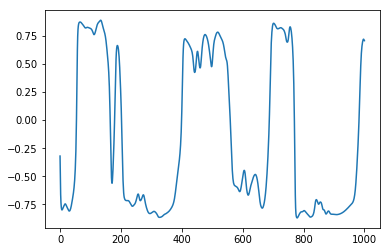

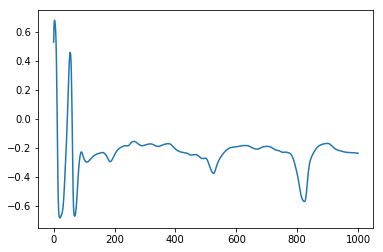

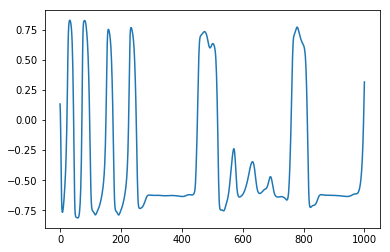

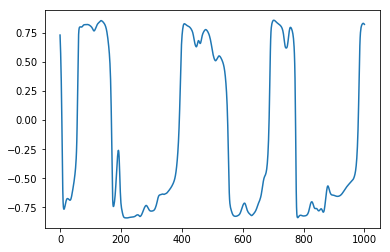

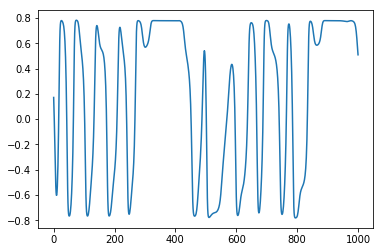

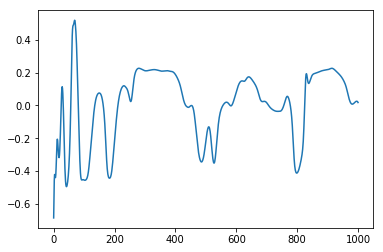

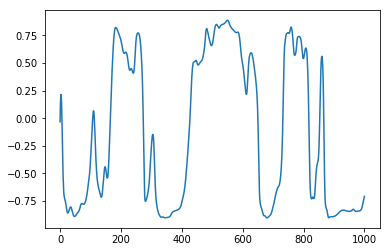

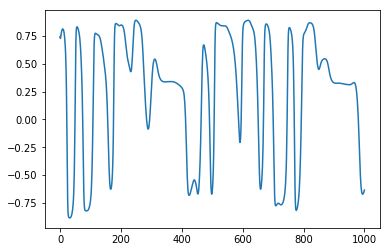

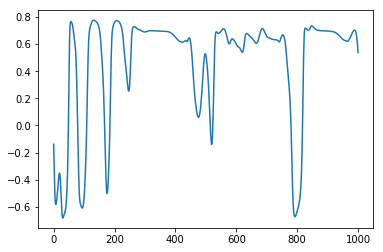

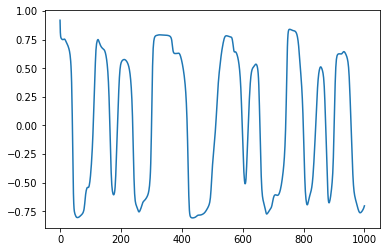

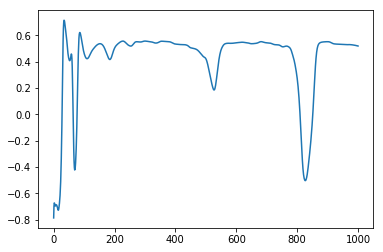

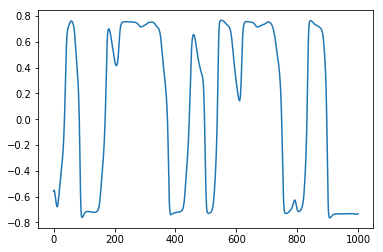

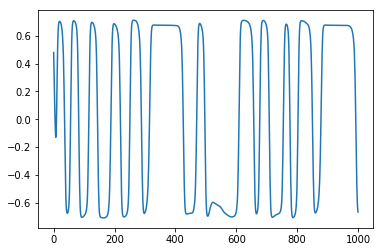

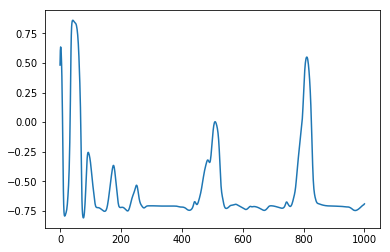

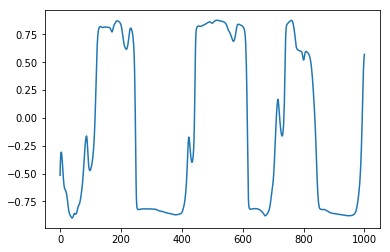

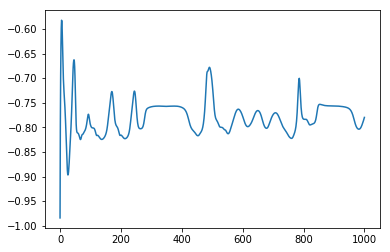

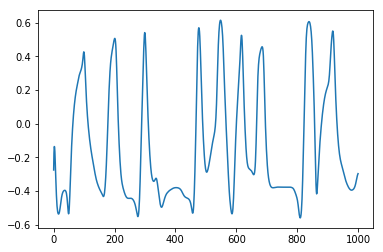

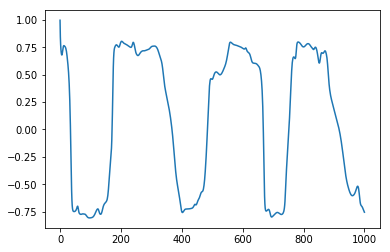

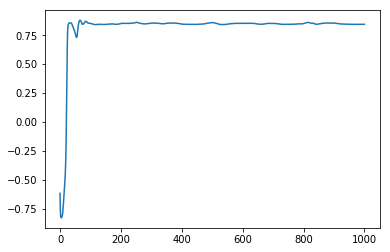

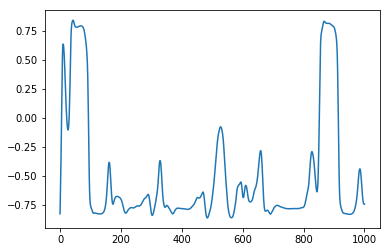

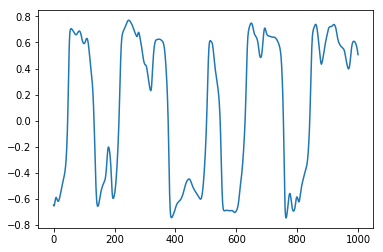

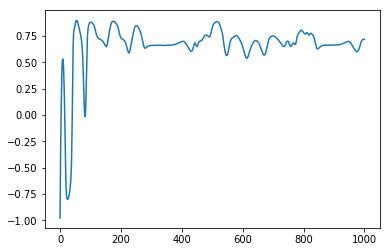

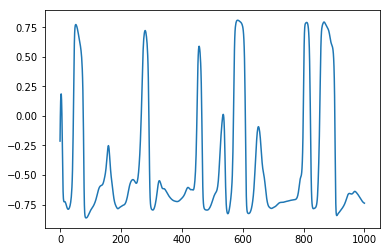

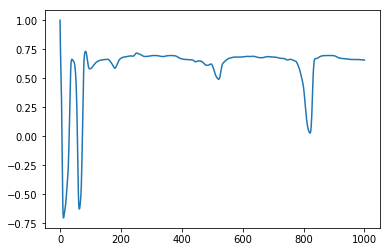

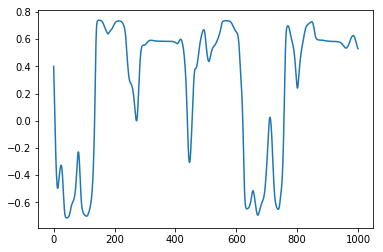

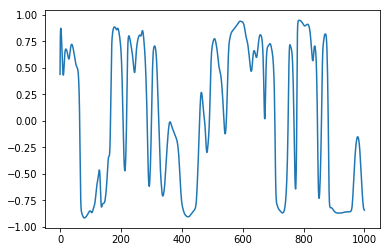

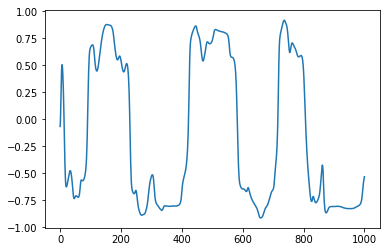

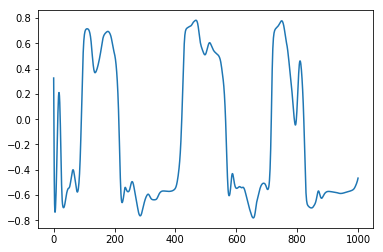

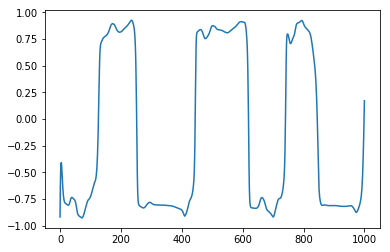

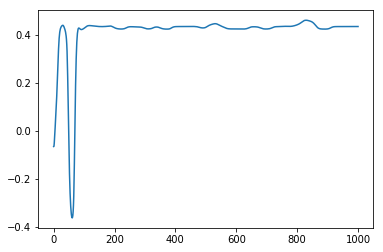

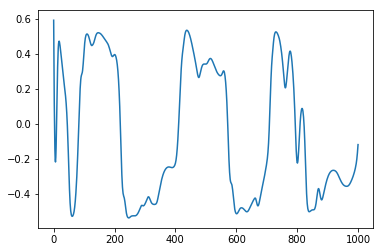

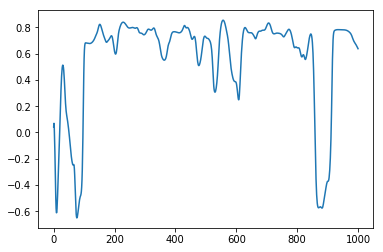

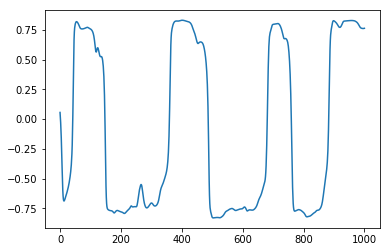

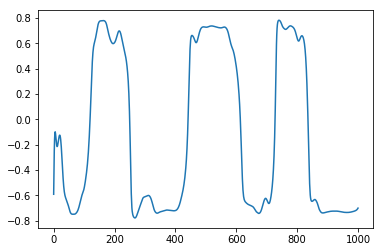

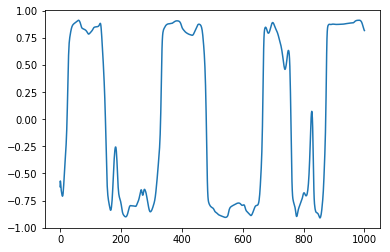

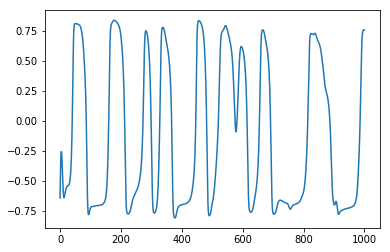

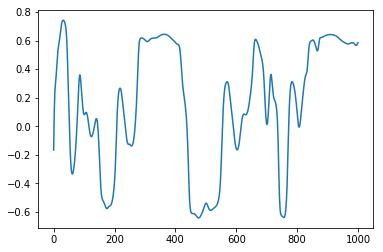

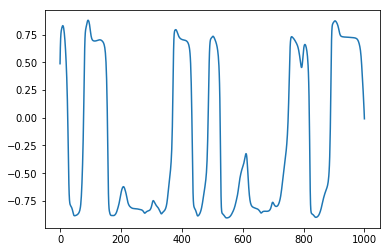

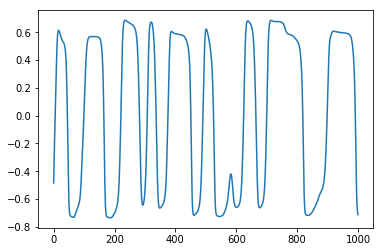

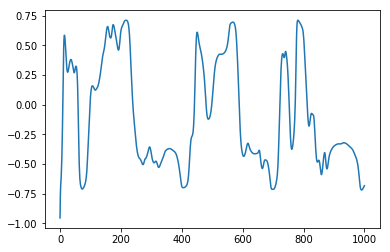

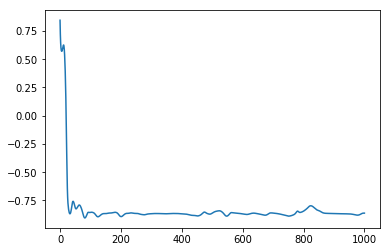

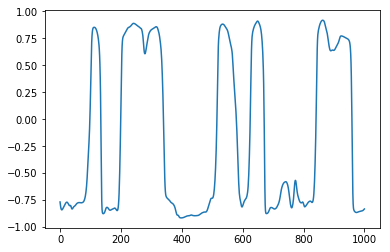

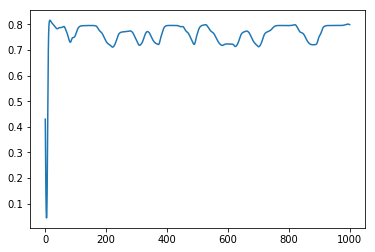

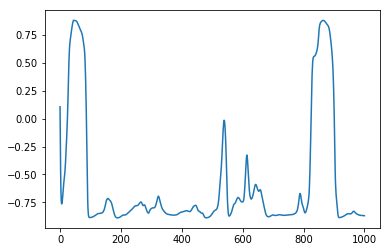

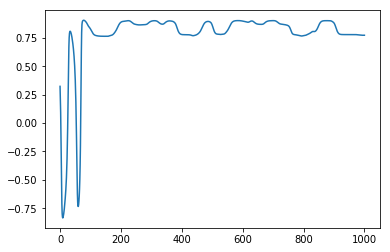

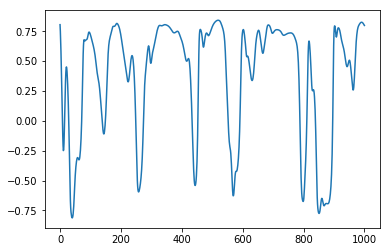

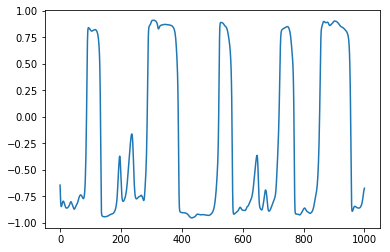

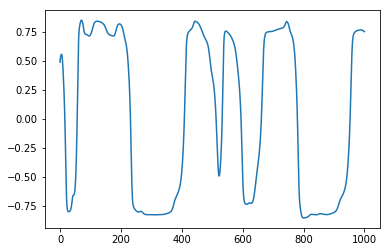

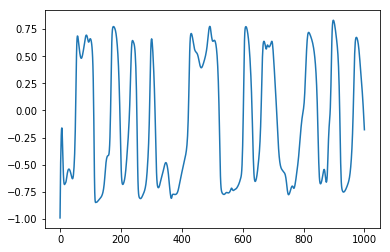

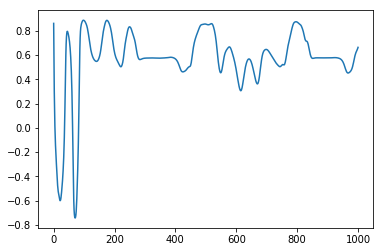

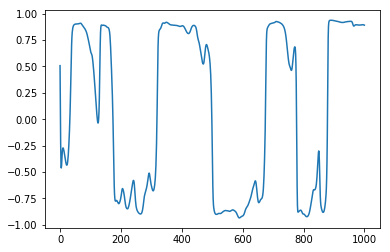

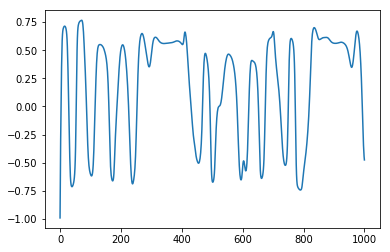

In [334]:
node_activations = a.get_internal_node_activations()
for i in range(100):
    fig, ax = plt.subplots()
    plt.plot(range(1001), node_activations[i])
    plt.show()